## 4. GLMのモデル選択

In [1]:
import numpy as np
from scipy.stats import poisson
import matplotlib.pyplot as plt
import polars as pl

/home/yoshino/.local/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
df = pl.read_csv('./data/chapter3/data3a.csv')
f2id = {'C': 0, 'T': 1}

# メモリの節約(今回はデータ数が少ないのでする必要はないけど、good practiceとして)
df = df.with_columns(
  [
    pl.col('y').cast(pl.datatypes.Int16),
    pl.col('x').cast(pl.datatypes.Float32),
    pl.col('f').apply(lambda x: f2id[x]).alias('f2').cast(pl.datatypes.Int8)
  ]
)
df.head()

y,x,f,f2
i16,f32,str,i8
6,8.31,"""C""",0
6,9.44,"""C""",0
6,9.5,"""C""",0
12,9.07,"""C""",0
10,10.16,"""C""",0


## 4.2 統計モデルのあてはまりの悪さ: 逸脱度

In [3]:
import statsmodels.api as sm
import statsmodels.formula.api as smf 

### xモデル

In [4]:
x_model = smf.glm(formula='y ~ x', data=df, family=sm.families.Poisson())

# logλ(i) = β1 + β2 * x(i) 
# 当てはまりの良さ(対数尤度): -235.39
# β1(Intercept: 切片)の最尤推定値: 1.29
# β2(xの傾き)の最尤推定値: 0.0757
#------------------------------
# Deviance: 残差逸脱度: 84.993
# 逸脱度: 最大対数尤度 * -2: -235.39 * 2
print(x_model.fit().summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  100
Model:                            GLM   Df Residuals:                       98
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -235.39
Date:                Mon, 16 Jan 2023   Deviance:                       84.993
Time:                        22:26:26   Pearson chi2:                     83.8
No. Iterations:                     4   Pseudo R-squ. (CS):            0.04414
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.2917      0.364      3.552      0.0

### nullモデル

In [5]:
null_model = smf.glm(formula='y ~ 1', data=df, family=sm.families.Poisson())

# Deviance: 残差逸脱度: 89.507
# 逸脱度: 最大対数尤度 * -2: -237.64 * 2
# 残差逸脱度がxモデルの(84.993)より大きくなっている
print(null_model.fit().summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  100
Model:                            GLM   Df Residuals:                       99
Model Family:                 Poisson   Df Model:                            0
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -237.64
Date:                Mon, 16 Jan 2023   Deviance:                       89.507
Time:                        22:26:26   Pearson chi2:                     87.1
No. Iterations:                     4   Pseudo R-squ. (CS):         -1.776e-15
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.0580      0.036     57.586      0.0

## 4.3 AIC(Akaie's information criterison)
```
AIC = -2 x{(最大対数尤度) - (最尤推定したpらメーター数)}
    = -2 (LogL* - K)
    = D(逸脱度) + 2k
```

In [6]:
f_model = smf.glm(formula='y ~ f2', data=df, family=sm.families.Poisson())
print(f_model.fit().summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  100
Model:                            GLM   Df Residuals:                       98
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -237.63
Date:                Mon, 16 Jan 2023   Deviance:                       89.475
Time:                        22:26:26   Pearson chi2:                     87.1
No. Iterations:                     4   Pseudo R-squ. (CS):          0.0003192
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.0516      0.051     40.463      0.0

In [7]:
xf_model = smf.glm(formula='y ~ x + f2', data=df, family=sm.families.Poisson())
print(xf_model.fit().summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  100
Model:                            GLM   Df Residuals:                       97
Model Family:                 Poisson   Df Model:                            2
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -235.29
Date:                Mon, 16 Jan 2023   Deviance:                       84.808
Time:                        22:26:26   Pearson chi2:                     83.8
No. Iterations:                     4   Pseudo R-squ. (CS):            0.04590
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.2631      0.370      3.417      0.0

|  model  |  最大対数尤度  | パラメータ数|
| ---- | ---- | --- |
|  null model  | -237.64  | 1 |
|  x model | -235.39  | 2 |
|  f model  | -237.63  | 2|
|  x f model  | -235.29 | 3 |

In [23]:
# AIC
print('null model: ', -237.64 * -2 + 2 * 1)
print('x model: ', -235.39 * -2 + 2 * 2)
print('f model: ', -237.63 * -2 + 2 * 2)
print('x f model: ', -235.29 * -2 + 2 * 3)

null model:  477.28
x model:  474.78
f model:  479.26
x f model:  476.58


In [24]:
# AICメソッドは用意されている
print('null model: ', null_model.fit().aic)
print('x model: ', x_model.fit().aic)
print('f model: ', f_model.fit().aic)
print('x f model: ', xf_model.fit().aic)


null model:  165.63438084512273
x model:  474.7725025785566
f model:  479.25451392137376
x f model:  476.5874395411329


## 4.5 なぜAICでモデル選択して良いか？

In [28]:
l = 8 # 真の値
y = np.random.poisson(l, 50)
data = pl.DataFrame(y, columns=['y'])
data.head()

y
i64
9
8
7
8
6


In [29]:
null_model = smf.glm(formula='y ~ 1', data=data, family=sm.families.Poisson())
result = null_model.fit()
print(result.summary())
print(np.exp(result.params[0])) # リンク関数に対数を利用しているので
print(result.llf)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                   50
Model:                            GLM   Df Residuals:                       49
Model Family:                 Poisson   Df Model:                            0
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -121.63
Date:                Mon, 16 Jan 2023   Deviance:                       50.133
Time:                        22:42:07   Pearson chi2:                     46.0
No. Iterations:                     4   Pseudo R-squ. (CS):              0.000
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.0744      0.050     41.385      0.0

In [53]:
def log_likelihood():
  l = 8 # 真の値
  y = np.random.poisson(l, 50)
  data = pl.DataFrame(y, columns=['y'])
  model = smf.glm(formula='y ~ 1', data=data, family=sm.families.Poisson())
  res = model.fit()
  return res.llf

llfs = []
results = []
for i in range(0, 500):
  llfs.append(log_likelihood())

  for j in range(1, 200):
    results.append(log_likelihood())
  avg_llf = np.mean(results)

In [54]:
bias = llfs - avg_llf
print(bias)

[ 2.38183783e+00 -3.16519121e+00 -1.94997591e+00  9.12600821e+00
 -2.39214741e+00 -7.05343861e-01 -1.51269089e-01  6.24606770e+00
 -2.40835235e+00  1.36409436e+00  4.82350472e-01  2.44192877e+00
 -6.79577557e-01 -2.57047235e-01 -1.37031606e+01 -5.93927039e+00
  3.18800791e+00  9.93339195e-01  1.34399783e+01  2.31463945e+00
  1.08299025e+01  1.11602146e+00  8.62732810e-01 -5.67055094e+00
  6.08810117e-01  3.89479858e+00  2.89309766e+00  2.05033540e+00
  7.93528481e+00 -1.83925263e+00  1.86289724e+00 -6.54080700e+00
  6.19467310e+00  1.07484512e+00 -7.24126295e+00 -1.22231023e+01
  5.48525489e+00 -5.64675914e+00  6.68223842e-01  1.78051853e+00
  9.67587490e-01 -2.94540093e+00 -5.37869330e+00 -4.06071993e+00
 -5.10103691e+00  2.70620665e+00  8.50654630e+00 -5.52257989e+00
 -4.74290957e+00 -4.65509728e+00  2.62226674e+00 -2.15736239e-01
  2.34014280e+00 -3.37593228e-01  6.63822776e+00  3.61554442e+00
  6.64543905e+00 -5.13104542e+00  1.79917644e+00  1.32156449e-01
 -7.59853413e+00 -7.53978

-0.29287593339503143

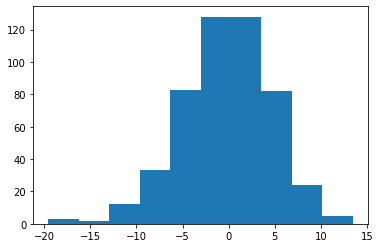

In [55]:
plt.hist(bias)
np.mean(bias) # 本当は1に近い値が出てほしい(平均対数尤度の出し方が間違っている？)